<a href="https://colab.research.google.com/github/InhuKim/study/blob/main/article_data_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install

In [ ]:
!pip install transformers
!pip install konlpy
!pip install soynlp

# Import

In [ ]:
import random
import pandas as pd
import numpy as np
import os
import gc
import csv
import math

from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from transformers import AutoModel, AutoTokenizer

from tqdm.auto import tqdm

import warnings
warnings.filterwarnings(action='ignore') 

# Setting

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

### Hyperparameter Setting

In [ ]:
CFG = {
    'EPOCHS':70,
    'LEARNING_RATE':1e-5,
    'BATCH_SIZE':32,
    'OUT_FEATURES':13,
    'SEED':41,
    'NSPLITS': 5,
    'MODEL': 'klue/roberta-base',
    'MODEL_NAME' : 'RoBERTa-base',
    "save_path" : "/content/drive/MyDrive/Colab_Notebooks/  ", # 결과물 저장 위치
    "NOTE" : 'base_long_token'  # 모델에 변화를 줄때마다 변경사항 표기.
}

In [ ]:
SAVEPOINT = {
    'checkpoint' : CFG['save_path'] + "result/checkpoint/",
    'loss_chart' : CFG['save_path'] + "chart/",
    'confusion_matrix' : CFG['save_path'] + "result/confusion_matrix/",
}

In [ ]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(CFG['SEED'])

### Draw graph

In [ ]:
def draw_graph(title, loss, valid_loss):
    plt.plot(loss, label="Training Loss")
    plt.plot(valid_loss, label="Validation Loss")
    plt.legend(loc='upper right')
    plt.title(title)
    plt.savefig(SAVEPOINT['loss_chart'] + title + ".png")
    plt.show()

In [ ]:
def draw_confusion_matrix(title, target, preds):
    cm = confusion_matrix(target, preds)
    splot = sns.heatmap(pd.DataFrame(cm), annot=True, cmap='YlGnBu', fmt='g')
    plt.title(title)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.savefig(SAVEPOINT['confusion_matrix'] + title + ".png")
    plt.show()

### Data Load

In [ ]:
article_data = pd.read_csv('/content/drive/MyDrive/Colab_Notebooks/data_test_5356.csv', encoding='utf8')

# EDA

#### target data

In [ ]:
article_data.loc[(article_data['분류명'] == "문헌정보학일반"), '분류명'] = 0
article_data.loc[(article_data['분류명'] == "정보/도서관정책"), '분류명'] = 0
article_data.loc[(article_data['분류명'] == "비교문헌정보학"), '분류명'] = 0
article_data.loc[(article_data['분류명'] == "도서관사"), '분류명'] = 0
article_data.loc[(article_data['분류명'] == "기록관리/보존"), '분류명'] = 1
article_data.loc[(article_data['분류명'] == "서지학"), '분류명'] = 2
article_data.loc[(article_data['분류명'] == "도서관/정보센터경영"), '분류명'] = 3
article_data.loc[(article_data['분류명'] == "정보서비스"), '분류명'] = 4
article_data.loc[(article_data['분류명'] == "정보자료/미디어"), '분류명'] = 5
article_data.loc[(article_data['분류명'] == "정보조직"), '분류명'] = 6
article_data.loc[(article_data['분류명'] == "분류"), '분류명'] = 6
article_data.loc[(article_data['분류명'] == "편목/메타데이터"), '분류명'] = 6
article_data.loc[(article_data['분류명'] == "색인/초록"), '분류명'] = 6
article_data.loc[(article_data['분류명'] == "전문용어/시소러스"), '분류명'] = 6
article_data.loc[(article_data['분류명'] == "정보검색"), '분류명'] = 7
article_data.loc[(article_data['분류명'] == "자동색인/요약"), '분류명'] = 7
article_data.loc[(article_data['분류명'] == "자동분류/클러스터링"), '분류명'] = 7
article_data.loc[(article_data['분류명'] == "검색모형/기법"), '분류명'] = 7
article_data.loc[(article_data['분류명'] == "데이터베이스"), '분류명'] = 7
article_data.loc[(article_data['분류명'] == "디지털도서관"), '분류명'] = 8
article_data.loc[(article_data['분류명'] == "정보공학"), '분류명'] = 9
article_data.loc[(article_data['분류명'] == "계량정보학"), '분류명'] = 10
article_data.loc[(article_data['분류명'] == "정보교육"), '분류명'] = 11
article_data.loc[(article_data['분류명'] == "기타문헌정보학"), '분류명'] = 12

In [ ]:
article_data.head(3)

,제목,영어제목,발행기관,학술지,대분류,중분류,등재구분,발행년월,권,호,통권,특별호,시작페이지,끝페이지,키워드,영문키워드,초록,영문 초록,피인용횟수,분류명
0,정보센터의 품질경영시스템 도입 인식도에 관한 실증적 연구,An Empirical Study on the Recognition for Qual...,한국정보관리학회,정보관리학회지,복합학,문헌정보학,KCI등재,200209,19.0,3,45.0,NaN,69.0,90.0,품질경영시스템;정보서비스 품질;도서관 경영;품질인증제도,ISO 9000;Quality Management System ISO 9000;In...,현대는 정보센터에서 제공하는 정보서비스의 품질을 고객이 요구하는 수준으로 제공하여야...,Modern stage must offer to the level which the...,0,3
1,네비게이션 정보추출에 의한 XML 본문검색시스템,XML Fulltext Retrieval System by Extracting Na...,한국정보관리학회,정보관리학회지,복합학,문헌정보학,KCI등재,200209,19.0,3,45.0,NaN,91.0,110.0,"구조문서, 구조문서검색, 네비게이션 정보, 본문검색, XML","XML, structured document, structured retrieval...","최근, 키워드 기반의 정보검색의 한계를 극복하기 위한 구조문서 기반의 연구가 활발하...","Recently, to overcome the limit of keyword bas...",0,7
2,로그 분석을 통한 이용자의 웹 문서 검색 형태에 관한 연구,Investigating Web Search Behavior via Query Lo...,한국정보관리학회,정보관리학회지,복합학,문헌정보학,KCI등재,200209,19.0,3,45.0,NaN,111.0,122.0,웹 검색;질의 로그 분석;검색 행태 분석,information seeking behavior;log analysis;quer...,본 연구에서는 웹 검색 이용자들의 전반적인 검색 행태를 이해하기 위하여 국내에서 널...,In order to investigate information seeking be...,10,7


In [ ]:
article_data.drop(["영어제목","대분류","중분류","등재구분","권","호","통권","특별호","영문 초록","피인용횟수","발행기관","발행년월","시작페이지","끝페이지"],axis=1, inplace=True)
article_data.head(3)

,제목,학술지,키워드,영문키워드,초록,분류명
0,정보센터의 품질경영시스템 도입 인식도에 관한 실증적 연구,정보관리학회지,품질경영시스템;정보서비스 품질;도서관 경영;품질인증제도,ISO 9000;Quality Management System ISO 9000;In...,현대는 정보센터에서 제공하는 정보서비스의 품질을 고객이 요구하는 수준으로 제공하여야...,3
1,네비게이션 정보추출에 의한 XML 본문검색시스템,정보관리학회지,"구조문서, 구조문서검색, 네비게이션 정보, 본문검색, XML","XML, structured document, structured retrieval...","최근, 키워드 기반의 정보검색의 한계를 극복하기 위한 구조문서 기반의 연구가 활발하...",7
2,로그 분석을 통한 이용자의 웹 문서 검색 형태에 관한 연구,정보관리학회지,웹 검색;질의 로그 분석;검색 행태 분석,information seeking behavior;log analysis;quer...,본 연구에서는 웹 검색 이용자들의 전반적인 검색 행태를 이해하기 위하여 국내에서 널...,7


In [ ]:
display(article_data.groupby('분류명', as_index=False).count())

,분류명,제목,학술지,키워드,영문키워드,초록
0,0,406,406,405,392,406
1,1,647,647,647,642,647
2,2,795,795,749,782,795
3,3,949,949,945,935,949
4,4,702,702,700,690,702
5,5,175,175,175,168,175
6,6,488,488,486,476,488
7,7,235,235,234,230,235
8,8,42,42,41,41,42
9,9,123,123,123,122,123


In [ ]:
tokenizer = AutoTokenizer.from_pretrained(CFG['MODEL'])

In [ ]:
tok_len = [[] for _ in range(13)]

for i, j in zip(article_data['초록'].values, article_data['분류명'].values):
    tok_len[j].append(len(tokenizer(i)['input_ids']))

Token indices sequence length is longer than the specified maximum sequence length for this model (543 > 512). Running this sequence through the model will result in indexing errors


In [ ]:
for k in range(13):
    display(f"{k}, max: {max(tok_len[k])}, min: {min(tok_len[k])}, mean: {np.mean(tok_len[k])}")

'0, max: 439, min: 76, mean: 206.6576354679803'

'1, max: 1644, min: 90, mean: 292.7527047913447'

'2, max: 1211, min: 78, mean: 358.8188679245283'

'3, max: 478, min: 68, mean: 214.08640674394098'

'4, max: 542, min: 90, mean: 217.23076923076923'

'5, max: 601, min: 80, mean: 223.44'

'6, max: 461, min: 39, mean: 220.17418032786884'

'7, max: 456, min: 90, mean: 218.23829787234044'

'8, max: 315, min: 131, mean: 187.26190476190476'

'9, max: 367, min: 109, mean: 225.1219512195122'

'10, max: 516, min: 124, mean: 253.14457831325302'

'11, max: 560, min: 66, mean: 212.01601423487546'

'12, max: 439, min: 96, mean: 214.46969696969697'

# Model Build

### Data Processing

In [ ]:
train, test, train_y, test_y = train_test_split(article_data['초록'], article_data['분류명'], test_size=0.2, random_state=CFG['SEED'])

In [ ]:
tra, val, tra_label, val_label = train_test_split(train, train_y, test_size=0.3, random_state=CFG['SEED'])

### Custom DataLoader

In [ ]:
# tokenization, 
def convert_examples_to_features(examples, max_seq_len):
    input_ids, attention_masks, token_type_ids = [], [], []
    tokenizer = AutoTokenizer.from_pretrained(CFG['MODEL'])

    for text in examples.values:
        inputs = tokenizer.encode_plus(text, return_tensors='pt', padding='max_length', max_length= max_seq_len, truncation= True)
        input_ids.append(inputs['input_ids'][0])
        attention_masks.append(inputs['attention_mask'][0])

    return input_ids, attention_masks

In [ ]:
ids, masks = convert_examples_to_features(tra, 256)
val_ids, val_masks = convert_examples_to_features(val, 256)

In [ ]:
test_ids, test_masks = convert_examples_to_features(test, 256)

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, ids, masks, label):
        self.ids = ids
        self.masks = masks
        self.label = label

    def __getitem__(self, index):

        if self.label is not None:
            return self.ids[index], self.masks[index], self.label[index]

        else:
            return self.ids[index], self.masks[index]

    def __len__(self):
        return len(self.ids)

In [ ]:
class IDsDataset(Dataset):
    def __init__(self, text, id, max_len, label):
        self.id = id
        self.text = text
        self.max_seq_len = max_len
        self.label = label
        tokenizer = AutoTokenizer.from_pretrained(CFG['MODEL'])

    def __getitem__(self, index):

        inputs = tokenizer.encode_plus(self.text[index], return_tensors='pt', padding='max_length', max_length= self.max_seq_len, truncation= True)

        return inputs['input_ids'][0], inputs['attention_mask'][0], self.label[index], self.id[index]

    def __len__(self):
        return len(self.id)

In [ ]:
train_dataset = CustomDataset(ids, masks, tra_label.values)
train_loader = DataLoader(train_dataset, batch_size = CFG['BATCH_SIZE'], shuffle=True, num_workers=0)

val_dataset = CustomDataset(val_ids, val_masks, val_label.values)
val_loader = DataLoader(val_dataset, batch_size = CFG['BATCH_SIZE'], shuffle=True, num_workers=0)

In [ ]:
test_dataset = CustomDataset(test_ids, test_masks, test_y.values)
test_loader = DataLoader(test_dataset, batch_size = CFG['BATCH_SIZE'], shuffle=False, num_workers=0)

In [ ]:
anal_dataset = IDsDataset(test.values, test.index.values, 128, test_y.values)
anal_loader = DataLoader(anal_dataset, batch_size = CFG['BATCH_SIZE'], shuffle=False, num_workers=0)

### Model

In [ ]:
class Roberta(nn.Module):

    def __init__(self):
        super(Roberta, self).__init__()
        
        self.model = AutoModel.from_pretrained(CFG['MODEL'])

        self.classifier = nn.Sequential(
            nn.Dropout(p=0.4),
            nn.Linear(in_features=768, out_features=384),
            nn.LeakyReLU(),
            nn.Linear(in_features=384, out_features=CFG['OUT_FEATURES']),
        )

    def forward(self, ids, masks):

        _, x = self.model(input_ids= ids, attention_mask=masks,return_dict=False)
        
        output = self.classifier(x)
        
        return output

# Train

In [ ]:
def train(model, optimizer, train_loader, val_loader, scheduler, device):
    
    model.to(device)
    criterion = nn.CrossEntropyLoss().to(device)

    
    best_f1 = 0
    best_model = None

    patience = 5
    earlystopping = 0

    loss_plot = []
    val_loss_plot = []


    print("--------------------------------------------")
    print("model : {}".format(CFG['MODEL']))
    print("learning rate : {}".format(CFG['LEARNING_RATE']))
    
    for epoch in range(1, CFG['EPOCHS']+1):
        model.train()
        train_loss = []
        for ids, masks, labels in tqdm(train_loader):
            
            id = ids.to(device)
            mask = masks.to(device)
            label = labels.to(device)
            
            optimizer.zero_grad()
            
            logit = model(ids = id, masks = mask)
            
            loss = criterion(logit, label)

            loss.backward()
            optimizer.step()
            
            train_loss.append(loss.item())
        
        val_loss, val_f1 = validation(model, val_loader, criterion, device)

        # draw graph
        loss_plot.append(np.mean(train_loss))
        val_loss_plot.append(val_loss)

        print(f'Epoch : [{epoch}] Train Loss : [{np.mean(train_loss):.5f}] Val Loss : [{val_loss:.5f}]] F1 - Score : [{val_f1:.5f}]')

        
        if scheduler is not None:
            scheduler.step(val_loss)
            
        if val_f1 > best_f1:
            best_f1 = val_f1
            best_model = model
            torch.save(model.state_dict(), SAVEPOINT['checkpoint'] + '{}_{}_{}.pth'.format(CFG['MODEL_NAME'], 'AdamW', CFG['NOTE']))
            print('------------------ Model Saved ------------------')
            earlystopping = 0

        elif val_f1 < best_f1:
            earlystopping += 1
            if earlystopping == patience:
                print("------------stop----------------")
                title = "{}_{}_epoch:{} loss, note: {}".format(CFG['MODEL_NAME'], 'AdamW', epoch, CFG['NOTE'])
                draw_graph(title, loss_plot, val_loss_plot)
                break
                
        if epoch == CFG['EPOCHS']:
            title = "{}_{}_epoch:{} loss, note{}".format(CFG['MODEL_NAME'], 'AdamW', epoch, CFG['NOTE'])
            draw_graph(title, loss_plot, val_loss_plot)

    return best_model

In [ ]:
def validation(model, val_loader, criterion, device):
    model.eval()
    val_loss = []
    
    val_preds = []
    val_labels = []
    

    with torch.no_grad():
        for ids, masks, labels in tqdm(val_loader):
    
            id = ids.to(device)
            mask = masks.to(device)
            label = labels.to(device)

            logit = model(ids = id, masks = mask)
            

            loss = criterion(logit, label)

            val_loss.append(loss.item())
            
            val_preds += logit.argmax(1).detach().cpu().numpy().tolist()
            val_labels += label.detach().cpu().numpy().tolist()
    
    f1 = f1_score(val_labels, val_preds, average='weighted')
    
    return np.mean(val_loss), f1

# Run

Some weights of the model checkpoint at klue/roberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.decoder.bias', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at klue/roberta-base and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for

--------------------------------------------
model : klue/roberta-base
learning rate : 1e-05


  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Epoch : [1] Train Loss : [2.33721] Val Loss : [2.01087]] F1 - Score : [0.45330]
------------------ Model Saved ------------------


  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Epoch : [2] Train Loss : [1.79882] Val Loss : [1.45077]] F1 - Score : [0.61264]
------------------ Model Saved ------------------


  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Epoch : [3] Train Loss : [1.35740] Val Loss : [1.15935]] F1 - Score : [0.67371]
------------------ Model Saved ------------------


  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Epoch : [4] Train Loss : [1.06546] Val Loss : [1.01585]] F1 - Score : [0.70328]
------------------ Model Saved ------------------


  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Epoch : [5] Train Loss : [0.86558] Val Loss : [0.90913]] F1 - Score : [0.73440]
------------------ Model Saved ------------------


  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Epoch : [6] Train Loss : [0.69472] Val Loss : [0.86154]] F1 - Score : [0.73714]
------------------ Model Saved ------------------


  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Epoch : [7] Train Loss : [0.58629] Val Loss : [0.84712]] F1 - Score : [0.74949]
------------------ Model Saved ------------------


  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Epoch : [8] Train Loss : [0.48111] Val Loss : [0.84964]] F1 - Score : [0.75881]
------------------ Model Saved ------------------


  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Epoch : [9] Train Loss : [0.40802] Val Loss : [0.87683]] F1 - Score : [0.76329]
------------------ Model Saved ------------------


  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Epoch : [10] Train Loss : [0.34970] Val Loss : [0.89775]] F1 - Score : [0.76209]
Epoch 00010: reducing learning rate of group 0 to 5.0000e-06.


  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Epoch : [11] Train Loss : [0.28862] Val Loss : [0.89408]] F1 - Score : [0.76833]
------------------ Model Saved ------------------


  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Epoch : [12] Train Loss : [0.25794] Val Loss : [0.90241]] F1 - Score : [0.76796]


  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Epoch : [13] Train Loss : [0.23375] Val Loss : [0.92900]] F1 - Score : [0.76780]
Epoch 00013: reducing learning rate of group 0 to 2.5000e-06.


  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Epoch : [14] Train Loss : [0.21254] Val Loss : [0.92427]] F1 - Score : [0.76901]
------------------ Model Saved ------------------


  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Epoch : [15] Train Loss : [0.19991] Val Loss : [0.93298]] F1 - Score : [0.76902]
------------------ Model Saved ------------------


  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Epoch : [16] Train Loss : [0.18794] Val Loss : [0.92822]] F1 - Score : [0.77506]
Epoch 00016: reducing learning rate of group 0 to 1.2500e-06.
------------------ Model Saved ------------------


  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Epoch : [17] Train Loss : [0.18295] Val Loss : [0.93132]] F1 - Score : [0.76931]


  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Epoch : [18] Train Loss : [0.17555] Val Loss : [0.93781]] F1 - Score : [0.77027]


  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Epoch : [19] Train Loss : [0.17462] Val Loss : [0.93993]] F1 - Score : [0.76976]
Epoch 00019: reducing learning rate of group 0 to 6.2500e-07.


  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Epoch : [20] Train Loss : [0.16572] Val Loss : [0.93649]] F1 - Score : [0.77074]


  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

Epoch : [21] Train Loss : [0.16239] Val Loss : [0.94121]] F1 - Score : [0.76829]
------------stop----------------


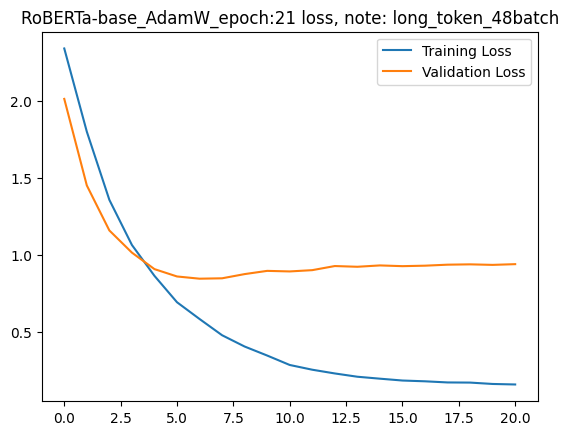

In [ ]:
model = Roberta().to(device)
model.eval()
optimizer = torch.optim.AdamW(params = model.parameters(), lr = CFG["LEARNING_RATE"])
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2,threshold_mode='abs',min_lr=1e-8, verbose=True)

infer_model = train(model, optimizer, train_loader, val_loader, scheduler, device)

# Evaluation

In [ ]:
def evaluation(model, val_loader, device):
    model.eval()
    val_loss = []
    criterion = nn.CrossEntropyLoss().to(device)
    
    val_preds = []
    val_labels = []
    

    with torch.no_grad():
        for ids, masks, labels in tqdm(val_loader):
    
            id = ids.to(device)
            mask = masks.to(device)
            label = labels.to(device)

            logit = model(ids = id, masks = mask)
            

            loss = criterion(logit, label)

            val_loss.append(loss.item())
            
            val_preds += logit.argmax(1).detach().cpu().numpy().tolist()
            val_labels += label.detach().cpu().numpy().tolist()
    
    f1 = f1_score(val_labels, val_preds, average='weighted')

    title = "{}_{}_score:{}_note:{}".format(CFG['MODEL_NAME'], 'AdamW', f1, CFG['NOTE']) 
    draw_confusion_matrix(title, val_labels, val_preds)
    
    return f1

In [ ]:
model = Roberta().to(device)
checkpoint_load = torch.load("/content/drive/MyDrive/Colab_Notebooks/NLP/paper_study/result/checkpoint/RoBERTa-base_AdamW_long_token_48batch.pth")

model.load_state_dict(checkpoint_load)

Some weights of the model checkpoint at klue/roberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.decoder.bias', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at klue/roberta-base and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for

<All keys matched successfully>

  0%|          | 0/23 [00:00<?, ?it/s]

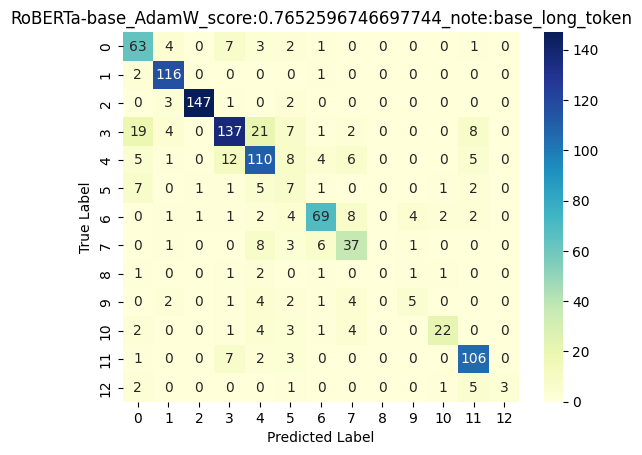

In [ ]:
_ = evaluation(model, test_loader, device)

 ------

# Analysis

### 데이터 분류 결과 정리

In [ ]:
# 초록과 키워드의 상관관계

article_data[:3]

,제목,학술지,키워드,영문키워드,초록,분류명
0,정보센터의 품질경영시스템 도입 인식도에 관한 실증적 연구,정보관리학회지,품질경영시스템;정보서비스 품질;도서관 경영;품질인증제도,ISO 9000;Quality Management System ISO 9000;In...,현대는 정보센터에서 제공하는 정보서비스의 품질을 고객이 요구하는 수준으로 제공하여야...,3
1,네비게이션 정보추출에 의한 XML 본문검색시스템,정보관리학회지,"구조문서, 구조문서검색, 네비게이션 정보, 본문검색, XML","XML, structured document, structured retrieval...","최근, 키워드 기반의 정보검색의 한계를 극복하기 위한 구조문서 기반의 연구가 활발하...",7
2,로그 분석을 통한 이용자의 웹 문서 검색 형태에 관한 연구,정보관리학회지,웹 검색;질의 로그 분석;검색 행태 분석,information seeking behavior;log analysis;quer...,본 연구에서는 웹 검색 이용자들의 전반적인 검색 행태를 이해하기 위하여 국내에서 널...,7


In [ ]:
# 학습 모델 불러오기
index_list = list(test.index.values)

model = Roberta().to(device)
checkpoint_load = torch.load("/content/drive/MyDrive/Colab_Notebooks/NLP/paper_study/result/checkpoint/RoBERTa-base_AdamW_baseline.pth")

model.load_state_dict(checkpoint_load)

Some weights of the model checkpoint at klue/roberta-base were not used when initializing RobertaModel: ['lm_head.bias', 'lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.bias', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at klue/roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for

<All keys matched successfully>

In [ ]:
# tokenization, 
def convert_to_features(examples, max_seq_len):
    input_ids, attention_masks, token_type_ids = [], [], []
    tokenizer = AutoTokenizer.from_pretrained(CFG['MODEL'])

    inputs = tokenizer.encode_plus(examples, return_tensors='pt', padding='max_length', max_length= max_seq_len, truncation= True)
    input_ids.append(inputs['input_ids'][0])
    attention_masks.append(inputs['attention_mask'][0])

    return input_ids, attention_masks

In [ ]:
# 자동분류 한 문서들의 예측값과 실제 레이블을 같이 return

def id_classification(model, test_loader, device):

    model.eval()
    
    val_preds = []
    val_labels = []

    correct_list = []
    wrong_list = []

    with torch.no_grad():
        for token, masks, labels, id in tqdm(test_loader):
    
            token = token.to(device)
            mask = masks.to(device)
            label = labels.detach().cpu().numpy().tolist()
            id = id

            logit = model(ids = token, masks = mask)
                        
            pred = logit.argmax(1).detach().cpu().numpy().tolist()

            for i, p in enumerate(pred):
                if p == label[i]:
                    correct_list.append([id[i], p, label[i]])
                else:
                    wrong_list.append([id[i], p, label[i]])

    return correct_list, wrong_list

In [ ]:
c_list, w_list = id_classification(model, anal_loader, device)

  0%|          | 0/34 [00:00<?, ?it/s]

In [ ]:
correct_id = [c_list[i][0] for i in range(len(c_list))]
worng_id = [w_list[i][0] for i in range(len(w_list))]

In [ ]:
# 정답 id csv 저장
cor_abs = article_data.loc[correct_id]

In [ ]:
for i in range(len(c_list)):
    c_list[i][0] = torch.IntTensor.item(c_list[i][0])

c_list[:5]

[[3283, 11, 11], [3862, 3, 3], [3163, 3, 3], [2530, 3, 3], [4460, 1, 1]]

In [ ]:
correct_label_df = pd.DataFrame(c_list, columns=['id', 'predction', 'label'])
correct_label_df

,id,predction,label
0,3283,11,11
1,3862,3,3
2,3163,3,3
3,2530,3,3
4,4460,1,1
...,...,...,...
819,2077,11,11
820,4058,5,5
821,4765,2,2
822,424,7,7


In [ ]:
# 오답 id csv 출력
wor_abs = article_data.loc[worng_id]

In [ ]:
for i in range(len(w_list)):
    w_list[i][0] = torch.IntTensor.item(w_list[i][0])

w_list[:5]

[[951, 3, 4], [3397, 4, 11], [3551, 11, 6], [1830, 0, 3], [1853, 3, 11]]

In [ ]:
wrong_label_df = pd.DataFrame(w_list, columns=['id', 'predction', 'label'])
wrong_label_df

,id,predction,label
0,951,3,4
1,3397,4,11
2,3551,11,6
3,1830,0,3
4,1853,3,11
...,...,...,...
243,134,5,0
244,3095,9,5
245,2091,6,4
246,3093,3,6


In [ ]:
correct_label_df.to_csv(CFG['save_path'] + 'correct_label.csv', index= False)
wrong_label_df.to_csv(CFG['save_path'] + 'wrong_label.csv', index= False)

### 자동분류 결과 데이터 로드

In [ ]:
correct_data = pd.read_csv(CFG['save_path'] + 'correct_label.csv')
wrong_data = pd.read_csv(CFG['save_path'] + 'wrong_label.csv')

correct_id = correct_data['id'].values
wrong_id = wrong_data['id'].values

In [ ]:
display(len(correct_data))
display(len(wrong_data))

824

248

In [ ]:
cor_abs = article_data.loc[correct_id]
wro_abs = article_data.loc[wrong_id]

In [ ]:
correct_data

,id,predction,label
0,3283,11,11
1,3862,3,3
2,3163,3,3
3,2530,3,3
4,4460,1,1
...,...,...,...
819,2077,11,11
820,4058,5,5
821,4765,2,2
822,424,7,7


### 초록과 키워드의 상관관계

 - 초록을 활용하여 자동분류를 실행한 후, 정답과 오답들의 초록에서 최빈도 단어를 추출하여 비교분석

##### 정분류, 오분류 최빈도 단어 - 초록 추출(konlpy-okt)

In [ ]:
from konlpy.tag import *
from nltk import Text

In [ ]:
okt = Okt()

In [ ]:
cor_list = []
wro_list = []
for i in tqdm(cor_abs['초록'].values):
    cor_list.append(okt.nouns(i))

for j in tqdm(wro_abs['초록'].values):
    wro_list.append(okt.nouns(j))

  0%|          | 0/824 [00:00<?, ?it/s]

  0%|          | 0/248 [00:00<?, ?it/s]

In [ ]:
cor_noun = []
wro_noun = []

for k in cor_list:
    for i in k:
        cor_noun.append(i)

for l in wro_list:
    for j in l:
        wro_noun.append(j)

In [ ]:
cor_text = Text(cor_noun)
wor_text = Text(wro_noun)

In [ ]:
cor_fd = cor_text.vocab()
wro_fd = wor_text.vocab()

# 고빈도 단어 확인 후 불용어 탐색을 위한 출력
#display(cor_fd.most_common(50))
#display(wro_fd.most_common(50))

In [ ]:
# stopword 제거

stop_words = ['것', '이', '및', '수', '위', '대한', '의', '등', '그', '위해', '개', '중', '즉', '요', '임', '함', '창', '작', '때', '여', '곳', '은', '는', '가', '점',
              ] + ['결과', '조사', '대상', '관련', '내용', '통해', '목적', '방법', '요소', '국내', '과정', '분야', '영향',] + ['대해', '환경', '또한', '가지']

correct_noun = [word for word in cor_noun if word not in stop_words]
wrong_noun = [word for word in wro_noun if word not in stop_words]

In [ ]:
cor_text = Text(correct_noun)
wro_text = Text(wrong_noun)

cor_fd = cor_text.vocab()
wro_fd = wro_text.vocab()

In [ ]:
cor_freq = cor_fd.most_common(50)
wro_freq = wro_fd.most_common(50)

In [ ]:
cor_highest_freq = [word[0] for word in cor_freq]
wro_highest_freq = [word[0] for word in wro_freq]

cor_freq_count = [word[1] for word in cor_freq]
wro_freq_count = [word[1] for word in wro_freq]

In [ ]:
freq_keyword_table = pd.DataFrame({
    'okt_cor_freq' : cor_highest_freq,
    'okt_cor_count' : cor_freq_count,
    'okt_wro_freq' : wro_highest_freq,
    'okt_wro_count' : wro_freq_count
})

freq_keyword_table[:20]

,okt_cor_freq,okt_cor_count,okt_wro_freq,okt_wro_count
0,도서관,1762,도서관,613
1,연구,1526,연구,488
2,분석,1059,분석,362
3,정보,931,정보,328
4,서비스,665,서비스,254
5,이용자,406,이용자,162
6,기록,376,자료,154
7,활용,371,이용,150
8,교육,369,독서,146
9,자료,360,사서,138


In [ ]:
freq_keyword_table.to_csv(CFG['save_path'] + 'high_frequency_keyword_okt.csv', index= False)

##### 정분류, 오분류 최빈도 단어 - 키워드 추출

In [ ]:
# 결측치 제거
cor_abs['키워드'] = cor_abs['키워드'].replace(np.nan, '없음')
wro_abs['키워드'] = wro_abs['키워드'].replace(np.nan, '없음')

In [ ]:
cor_key_list = []
wro_key_list = []

for i in tqdm(cor_abs['키워드'].values):
    cor_key_list.append(okt.nouns(str(i)))

for j in tqdm(wro_abs['키워드'].values):
        wro_key_list.append(okt.nouns(str(j)))

  0%|          | 0/824 [00:00<?, ?it/s]

  0%|          | 0/248 [00:00<?, ?it/s]

In [ ]:
cor_key_list[:20]

In [ ]:
cor_key_noun = []
wro_key_noun = []

for k in cor_key_list:
    for i in k:
        cor_key_noun.append(i)

for l in wro_key_list:
    for j in l:
        wro_key_noun.append(j)

In [ ]:
cor_key_text = Text(cor_key_noun)
wro_key_text = Text(wro_key_noun)

In [ ]:
cor_key_fd = cor_key_text.vocab()
wro_key_fd = wro_key_text.vocab()

In [ ]:
cor_key_fd.most_common(50)

[('도서관', 581),
 ('정보', 234),
 ('서비스', 155),
 ('평가', 91),
 ('독서', 88),
 ('분석', 82),
 ('교육', 82),
 ('기록', 77),
 ('연구', 74),
 ('학교', 71),
 ('대학', 70),
 ('분류', 68),
 ('사서', 68),
 ('이용자', 62),
 ('시스템', 58),
 ('관리', 57),
 ('기록관리', 53),
 ('이용', 51),
 ('정책', 50),
 ('문화', 47),
 ('디지털', 45),
 ('프로그램', 43),
 ('활용', 43),
 ('법', 41),
 ('기록물', 39),
 ('아카이브', 37),
 ('검색', 37),
 ('모형', 37),
 ('능력', 36),
 ('전자', 35),
 ('체계', 34),
 ('목록', 34),
 ('자료', 33),
 ('학습', 32),
 ('보존', 32),
 ('기술', 31),
 ('웹', 31),
 ('어린이', 31),
 ('데이터', 30),
 ('국가', 29),
 ('한국', 29),
 ('주제', 29),
 ('독서치료', 28),
 ('인용', 28),
 ('지식', 27),
 ('기준', 26),
 ('공간', 26),
 ('지역', 25),
 ('네트워크', 25),
 ('장서', 25)]

In [ ]:
cor_keyword_set = cor_key_fd.most_common(50)
wro_keyword_set = wro_key_fd.most_common(50)

cor_keyword_freq = [word[0] for word in cor_keyword_set]
wro_keyword_freq = [word[0] for word in wro_keyword_set]

cor_keyword_count = [word[1] for word in cor_keyword_set]
wro_keyword_count = [word[1] for word in wro_keyword_set]

In [ ]:
freq_keyword_table = pd.DataFrame({
    'cor_freq' : cor_keyword_freq,
    'cor_count' : cor_keyword_count,
    'wro_freq' : wro_keyword_freq,
    'wro_count' : wro_keyword_count
})

freq_keyword_table[:20]

,cor_freq,cor_count,wro_freq,wro_count
0,도서관,581,도서관,171
1,정보,234,정보,88
2,서비스,155,서비스,57
3,평가,91,분석,47
4,독서,88,독서,41
5,분석,82,사서,36
6,교육,82,연구,30
7,기록,77,대학,29
8,연구,74,교육,25
9,학교,71,학교,24


In [ ]:
freq_keyword_table.to_csv(CFG['save_path'] + 'high_frequency_keyword_keyword_extracted.csv', index= False)

##### 초록 데이터와 저자 입력 키워드 비교분석

 - 초록 데이터를 KRWordRank와 Konlpy Okt 라이브러리를 사용하여 명사 추출
 - 키워드 데이터는 Konlpy Okt 라이브러리를 사용해서 추출.
 - 명사로 추출한 각 데이터를 비교분석

In [ ]:
okt_freq = pd.read_csv(CFG['save_path'] + 'high_frequency_keyword_okt.csv')
keyword_freq = pd.read_csv(CFG['save_path'] + 'high_frequency_keyword_keyword_extracted.csv')

In [ ]:
all_df = okt_freq.join(keyword_freq, how='left')
all_df[:50]

table = pd.DataFrame({
    'Abs_correct' : okt_freq['okt_cor_freq'][:50],
    'Abs_correct_count' : okt_freq['okt_cor_count'][:50],
    'Abs_wrong': okt_freq['okt_wro_freq'][:50],
    'Abs_wrong_count' : okt_freq['okt_wro_count'][:50],
    'Key_correct': keyword_freq['cor_freq'][:50],
    'Key_correct_count' : keyword_freq['cor_count'][:50],
    'Key_wrong': keyword_freq['wro_freq'][:50],
    'Key_wrong_count' : keyword_freq['wro_count'][:50]
})

table

,Abs_correct,Abs_correct_count,Abs_wrong,Abs_wrong_count,Key_correct,Key_correct_count,Key_wrong,Key_wrong_count
0,도서관,1762,도서관,613,도서관,581,도서관,171
1,연구,1526,연구,488,정보,234,정보,88
2,분석,1059,분석,362,서비스,155,서비스,57
3,정보,931,정보,328,평가,91,분석,47
4,서비스,665,서비스,254,독서,88,독서,41
5,이용자,406,이용자,162,분석,82,사서,36
6,기록,376,자료,154,교육,82,연구,30
7,활용,371,이용,150,기록,77,대학,29
8,교육,369,독서,146,연구,74,교육,25
9,자료,360,사서,138,학교,71,학교,24


In [ ]:
table.to_csv(CFG['save_path'] + 'table_high_frequency.csv', index= False)

 - 분석 결과
 - '기록'과 연관된 단어들이 독특하게 오분류에 등장하지 않음.
 - 기록관리학 관련 논문들은 모두 정분류에서 고빈도로 나타나고 해당 단어가 딥러닝 모델 학습에서 학습이 잘 되었다는 것을 보여줌.
 - 오분류 단어에서는 데이터, 프로그램, 웹, 메타데이터와 같은 공학적인 단어들이 오분류에서 자주 보이는데 이런 공학과 연관된 분류 항목은 학습이 잘 이루어지지 않았다는 것을 보여줌.